In [1]:
import networkx as nx
import json
import glob
import os
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from epilepsypcm.utils.make_df import make_df, get_df_list, concat_dfs
from epilepsypcm.utils.outcome_params import engel_score
from epilepsypcm.utils.outcome_params import seizure_onset_zone, engel_score

In [2]:
base_path = '/Users/richardlee/Desktop/2021 Fall/Precision Care Medicine/Coding/'

patient_files = os.listdir(base_path)
positive_dataframes = []
response_path = '/Users/richardlee/Desktop/2021 Fall/Precision Care Medicine/Coding/PY16N008/ResponseInfo/CCEP'
response_files_path = response_files_path = glob.glob(response_path + '/*.json', recursive=True)
len(response_files_path) # =11
respFile = response_files_path[0]
print(respFile.split("_"))

['/Users/richardlee/Desktop/2021 Fall/Precision Care Medicine/Coding/PY16N008/ResponseInfo/CCEP/PY16N008', 'RPTI26', 'RPTI27', '5ma', 'ResponseInfo.json']


In [3]:
def make_df_forNetwork(patient,paths):
    n = 0
    stimChs = []
    for i in range(len(paths)):
        chNames = []
        # load info into python dictionary
        data = json.load(open(paths[i]))

        # Get list of channel names
        for key in data["time"]: chNames.append(key)
        
        if n < 1:
            significant = np.empty((len(paths), len(chNames)))
            n1Zscore = np.empty((len(paths), len(chNames)))
            n2Zscore = np.empty((len(paths), len(chNames)))
            p2Zscore = np.empty((len(paths), len(chNames)))
            n1Latency = np.empty((len(paths), len(chNames)))
            n += 1
        
        for j in range(len(chNames)):
            significant[i][j] = data['significant'][chNames[j]]
            n1Zscore[i][j] = data['zscores'][chNames[j]]['n1'][1]
            n2Zscore[i][j] = data['zscores'][chNames[j]]['n2'][1]
            p2Zscore[i][j] = data['zscores'][chNames[j]]['p2'][1]
            n1Latency[i][j] = data['zscores'][chNames[j]]['n1'][0] + data['window'][0] * data["samplingRate"] / 1000
        
        stimChs = stimChs + [paths[i].split("_")[1] + "_" + paths[i].split("_")[2]]*len(chNames)

    df = pd.DataFrame()
    df["stimChs"] = stimChs
    df["respChs"] = chNames * len(paths)
    df["significant"] = significant.flatten()
    df["n1Zscore"] = n1Zscore.flatten()
    df["n2Zscore"] = n2Zscore.flatten()
    df["p2Zscore"] = p2Zscore.flatten()
    df["n1Latency"] = n1Latency.flatten()

    
    df["outcome"] = np.zeros(df.shape[0])
    if engel_score[patient] == "1":
        if seizure_onset_zone[patient] != "None":
            for node in seizure_onset_zone[patient]:
                for channel in df["respChs"]:
                    if node in channel:
                        #df["outcome"][df["chNames"] == channel] = 1
                        df.loc[df['respChs']==channel, ['outcome']] = 1

    return df


In [45]:
response_path = '/Users/richardlee/Desktop/2021 Fall/Precision Care Medicine/Coding/PY21N008/ResponseInfo/CCEP'
response_files_path = response_files_path = glob.glob(response_path + '/*.json', recursive=True)

D = make_df_forNetwork("PY21N008",response_files_path)
D[D.significant==1]

,stimChs,respChs,significant,n1Zscore,n2Zscore,p2Zscore,n1Latency,outcome
16,LFOA1_LFOA2,LAH8_LAH9,1.0,-6.104519,-2.992231,0.553621,15.0,0.0
23,LFOA1_LFOA2,LPH7_LPH8,1.0,-8.746908,-3.230834,4.223770,17.0,0.0
41,LFOA1_LFOA2,LFOA3_LFOA4,1.0,112.790146,18.845888,-34.040003,11.0,0.0
42,LFOA1_LFOA2,LFOA4_LFOA5,1.0,230.892619,99.288677,-48.135259,12.0,0.0
43,LFOA1_LFOA2,LFOA5_LFOA6,1.0,36.665426,44.657314,-12.275180,11.0,0.0
...,...,...,...,...,...,...,...,...
2800,LFOP3_LFOP4,LOF11_LOF12,1.0,-6.218216,-2.260339,10.211699,51.0,0.0
2801,LFOP3_LFOP4,LOF12_LOF13,1.0,-6.045523,-4.365321,6.020905,28.0,0.0
2811,LFOP3_LFOP4,RA9_RA10,1.0,-7.025819,-8.802977,-1.208769,26.0,1.0
2812,LFOP3_LFOP4,RAH1_RAH2,1.0,-7.531260,-5.706361,0.314957,37.0,1.0


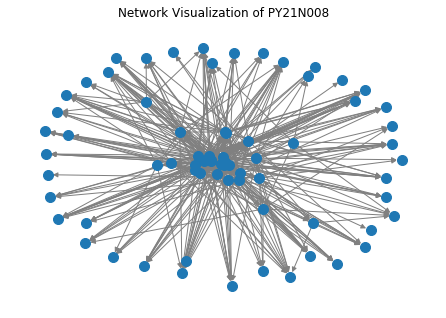

In [46]:
G = nx.DiGraph()
for i in range(D.shape[0]):
    if D.significant[i] == 1:
        G.add_edge(D.stimChs[i],D.respChs[i])

nx.draw(G,node_size = 100, edge_color='grey')
plt.title("Network Visualization of PY21N008")
plt.savefig('Network_PY21N008.png')
plt.show()

In [22]:
G.out_degree()

OutDegreeView({'RPTI26_RPTI27': 8, 'RABT1_RABT2': 26, 'RPTI17_RPTI18': 0, 'RPTI18_RPTI19': 0, 'RPTI19_RPTI20': 30, 'RPTI20_RPTI21': 0, 'RPTS49_RPTS50': 0, 'RPTS57_RPTS58': 0, 'RPTS58_RPTS59': 0, 'RATS1_RATS2': 0, 'RATS2_RATS3': 0, 'RATI3_RATI4': 0, 'RATI4_RATI5': 0, 'RATI5_RATI6': 0, 'RATI6_RATI7': 0, 'RATI7_RATI8': 3, 'RATI11_RATI12': 0, 'RATI12_RATI13': 0, 'RATI13_RATI14': 0, 'RATI14_RATI15': 0, 'RATI15_RATI16': 0, 'RABT3_RABT4': 0, 'RMBT1_RMBT2': 0, 'RMBT2_RMBT3': 25, 'RPTI22_RPTI23': 0, 'RPTI23_RPTI24': 0, 'RPTI25_RPTI26': 0, 'RPTI27_RPTI28': 0, 'RPTI29_RPTI30': 0, 'RPTS63_RPTS64': 0, 'RPFS1_RPFS2': 0, 'RPFS2_RPFS3': 0, 'RPFS3_RPFS4': 0, 'RATI9_RATI10': 0, 'RABT2_RABT3': 0, 'RPTI28_RPTI29': 0, 'RPTI30_RPTI31': 0, 'RPTI31_RPTI32': 0, 'RPFS5_RPFS6': 0, 'RPFS6_RPFS7': 0, 'RPFI1_RPFI2': 0, 'RPFI2_RPFI3': 0, 'RATS3_RATS4': 2, 'RPTS49_RPTS57': 11, 'RPTS50_RPTS51': 0, 'RPTS51_RPTS52': 0, 'RPTS59_RPTS60': 0, 'RPFS4_RPFS5': 5, 'RPFS7_RPFS8': 0, 'RPFI3_RPFI4': 0, 'RPTS50_RPTS58': 10, 'RPTS60

In [23]:
G.in_degree()

InDegreeView({'RPTI26_RPTI27': 4, 'RABT1_RABT2': 2, 'RPTI17_RPTI18': 5, 'RPTI18_RPTI19': 3, 'RPTI19_RPTI20': 3, 'RPTI20_RPTI21': 2, 'RPTS49_RPTS50': 1, 'RPTS57_RPTS58': 2, 'RPTS58_RPTS59': 4, 'RATS1_RATS2': 2, 'RATS2_RATS3': 1, 'RATI3_RATI4': 2, 'RATI4_RATI5': 2, 'RATI5_RATI6': 3, 'RATI6_RATI7': 2, 'RATI7_RATI8': 2, 'RATI11_RATI12': 3, 'RATI12_RATI13': 4, 'RATI13_RATI14': 4, 'RATI14_RATI15': 4, 'RATI15_RATI16': 2, 'RABT3_RABT4': 2, 'RMBT1_RMBT2': 2, 'RMBT2_RMBT3': 2, 'RPTI22_RPTI23': 5, 'RPTI23_RPTI24': 4, 'RPTI25_RPTI26': 3, 'RPTI27_RPTI28': 6, 'RPTI29_RPTI30': 4, 'RPTS63_RPTS64': 3, 'RPFS1_RPFS2': 1, 'RPFS2_RPFS3': 2, 'RPFS3_RPFS4': 2, 'RATI9_RATI10': 3, 'RABT2_RABT3': 2, 'RPTI28_RPTI29': 3, 'RPTI30_RPTI31': 2, 'RPTI31_RPTI32': 2, 'RPFS5_RPFS6': 1, 'RPFS6_RPFS7': 3, 'RPFI1_RPFI2': 2, 'RPFI2_RPFI3': 2, 'RATS3_RATS4': 0, 'RPTS49_RPTS57': 0, 'RPTS50_RPTS51': 3, 'RPTS51_RPTS52': 4, 'RPTS59_RPTS60': 3, 'RPFS4_RPFS5': 0, 'RPFS7_RPFS8': 2, 'RPFI3_RPFI4': 2, 'RPTS50_RPTS58': 0, 'RPTS60_RPTS6

In [24]:
df = pd.DataFrame()
df["Nodes"]= pd.DataFrame.from_dict(G.out_degree)[0]
df["Out_Degree"] = pd.DataFrame.from_dict(G.out_degree)[1]
df["In_Degree"] = pd.DataFrame.from_dict(G.in_degree)[1]
df

,Nodes,Out_Degree,In_Degree
0,RPTI26_RPTI27,8,4
1,RABT1_RABT2,26,2
2,RPTI17_RPTI18,0,5
3,RPTI18_RPTI19,0,3
4,RPTI19_RPTI20,30,3
5,RPTI20_RPTI21,0,2
6,RPTS49_RPTS50,0,1
7,RPTS57_RPTS58,0,2
8,RPTS58_RPTS59,0,4
9,RATS1_RATS2,0,2


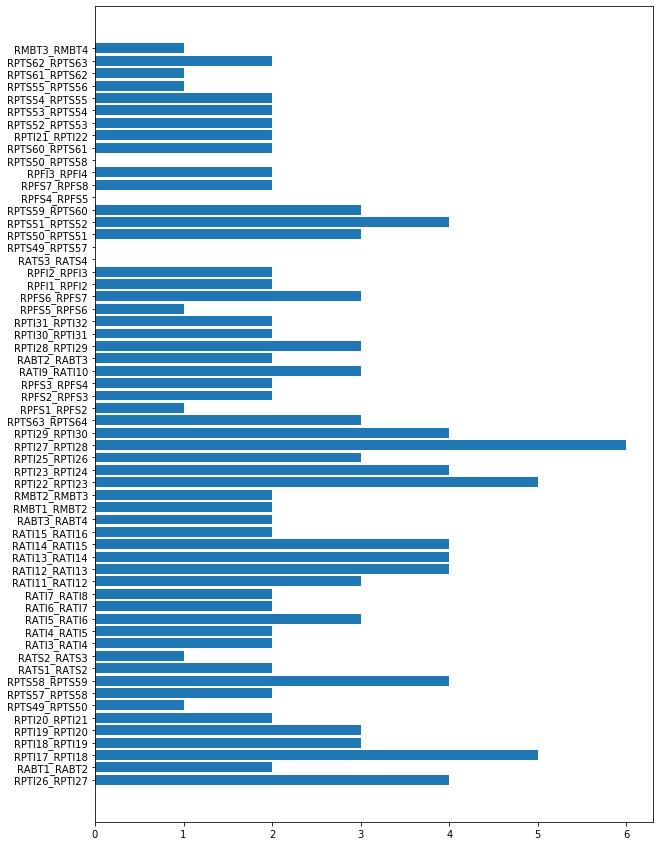

In [38]:
Nodes = df.Nodes.tolist()
In_Degree = df.In_Degree.tolist()
Out_Degree = df.Out_Degree.tolist()
plt.figure(figsize=(10,15))
plt.barh(Nodes,In_Degree)
plt.savefig('InDegree_PY21N008')

<BarContainer object of 60 artists>

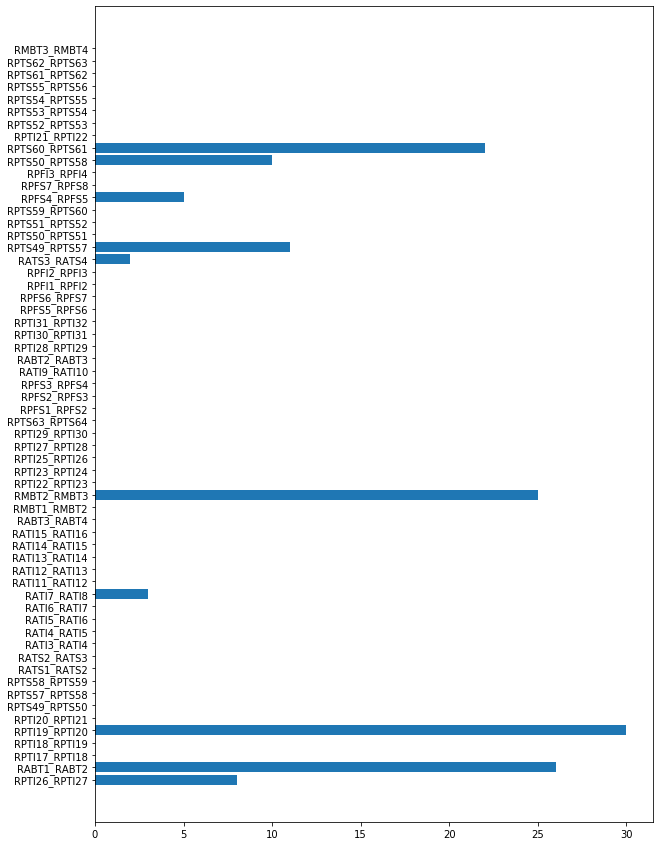

In [37]:
plt.figure(figsize=(10,15))
plt.barh(Nodes,Out_Degree)